In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model

In [57]:
df = pd.read_csv("admData20.csv")

In [58]:
target = df.AdmittedNum.values

In [59]:
trainPortion = round(target.shape[0]*0.7)
valPortion = round(target.shape[0]*0.15)

In [60]:
trainData = target[:trainPortion]
valData = target[trainPortion:trainPortion + valPortion]
testData = target[trainPortion+valPortion:]

In [61]:
trainData = trainData.reshape(-1,1)
valData = valData.reshape(-1,1)
testData = testData.reshape(-1,1)

In [62]:
sc = MinMaxScaler(feature_range=(0,1))
sc.fit(trainData)
trainNorm = sc.transform(trainData)
valNorm = sc.transform(valData)
testNorm = sc.transform(testData)

In [63]:
def createSeq(dataset, look_back=4, foresight=3):
    X,Y=[],[]
    for i in range(len(dataset)-look_back-foresight):
        obs = dataset[i:(i+look_back),0]
        X.append(obs)
        Y.append(dataset[(i+look_back): (i + (look_back +foresight)),0])
    return np.array(X),np.array(Y)

In [64]:
trainNormX, trainNormY = createSeq(trainNorm,2,5)

In [65]:
valNormX, valNormY = createSeq(valNorm,2,5)
testNormX, testNormY = createSeq(testNorm,2,5)

In [66]:
trainNormX = np.reshape(trainNormX, (trainNormX.shape[0],trainNormX.shape[1],1))
valNormX = np.reshape(valNormX, (valNormX.shape[0],valNormX.shape[1],1))
testNormX = np.reshape(testNormX, (testNormX.shape[0],testNormX.shape[1],1))

trainNormY = np.reshape(trainNormY, (trainNormY.shape[0],trainNormY.shape[1],1))
valNormY = np.reshape(valNormY, (valNormY.shape[0],valNormY.shape[1],1))
testNormY = np.reshape(testNormY, (testNormY.shape[0],testNormY.shape[1],1))

In [67]:
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from keras.layers import Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [68]:
trainNormX.shape[1:]

(2, 1)

## LSTM

In [69]:
model = Sequential()
model.add(LSTM(24, input_shape = trainNormX.shape[1:], dropout = 0.1, recurrent_dropout = 0.1))
model.add(Dense(5, activation = "linear"))
model.compile(loss="mae", optimizer="adam",metrics=["mean_absolute_error"])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 24)                2496      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 125       
Total params: 2,621
Trainable params: 2,621
Non-trainable params: 0
_________________________________________________________________


In [70]:
# ONLY USE FOR BEST MODEL SELECTION
# network_name = "lstm"
# filepath = network_name + "_epoch-{epoch:02d}-loss-{loss:.4f}-.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor="val_loss", verbose=0, save_best_only=True, mode="min")
# callbacks_list = [checkpoint]
network = model.fit(trainNormX, trainNormY, validation_data=(valNormX, valNormY), epochs=100, batch_size=2)

Train on 96 samples, validate on 15 samples
Epoch 1/100
96/96 [==============================] - 1s 6ms/step - loss: 0.1992 - mean_absolute_error: 0.1992 - val_loss: 0.2373 - val_mean_absolute_error: 0.2373
Epoch 2/100
96/96 [==============================] - 0s 1ms/step - loss: 0.1819 - mean_absolute_error: 0.1819 - val_loss: 0.2252 - val_mean_absolute_error: 0.2252
Epoch 3/100
96/96 [==============================] - 0s 1ms/step - loss: 0.1767 - mean_absolute_error: 0.1767 - val_loss: 0.2178 - val_mean_absolute_error: 0.2178
Epoch 4/100
96/96 [==============================] - 0s 1ms/step - loss: 0.1719 - mean_absolute_error: 0.1719 - val_loss: 0.2135 - val_mean_absolute_error: 0.2135
Epoch 5/100
96/96 [==============================] - 0s 1ms/step - loss: 0.1695 - mean_absolute_error: 0.1695 - val_loss: 0.2080 - val_mean_absolute_error: 0.2080
Epoch 6/100
96/96 [==============================] - 0s 1ms/step - loss: 0.1682 - mean_absolute_error: 0.1682 - val_loss: 0.2048 - val_mean_a

Epoch 100/100
96/96 [==============================] - 0s 930us/step - loss: 0.1243 - mean_absolute_error: 0.1243 - val_loss: 0.1406 - val_mean_absolute_error: 0.1406


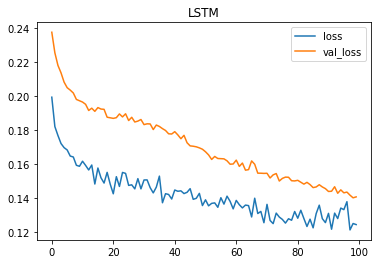

In [71]:
plt.plot(network.history["loss"], label="loss")
plt.plot(network.history["val_loss"], label="val_loss")
plt.legend()
plt.title("LSTM")
plt.show()

In [72]:
lstmbest = load_model("lstm_epoch-98-loss-0.1130-.hdf5")

In [73]:
print("MAE for LSTM is:",lstmbest.evaluate(testNormX,testNormY)[1])

15/15 [==============================] - 0s 4ms/step
MAE for LSTM is: 0.10972357541322708


In [74]:
preds = lstmbest.predict(testNormX)

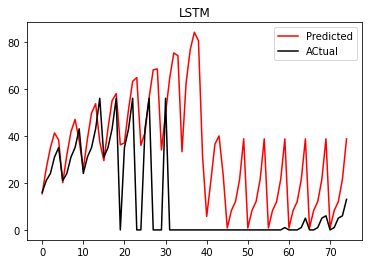

In [75]:
plt.plot(sc.inverse_transform(preds).reshape(-1,1), label="Predicted", color="red")
plt.plot(sc.inverse_transform(testNormY).reshape(-1,1), label="ACtual", color="black")
plt.legend()
plt.title("LSTM")
plt.show()

## GRU

In [76]:
GRUmodel = Sequential()
GRUmodel.add(GRU(24, input_shape = trainNormX.shape[1:], dropout = 0.1, recurrent_dropout = 0.1))
GRUmodel.add(Dense(5, activation = "linear"))
GRUmodel.compile(loss="mae", optimizer="adam",metrics=["mean_absolute_error"])
GRUmodel.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 24)                1872      
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 125       
Total params: 1,997
Trainable params: 1,997
Non-trainable params: 0
_________________________________________________________________


In [77]:
# ONLY USE FOR BEST MODEL SELECTION
# network_name = "GRU"
# filepath = network_name + "_epoch-{epoch:02d}-loss-{loss:.4f}-.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor="val_loss", verbose=0, save_best_only=True, mode="min")
# callbacks_list = [checkpoint]
network1 = GRUmodel.fit(trainNormX, trainNormY, validation_data=(valNormX, valNormY), epochs=100, batch_size=2)

Train on 96 samples, validate on 15 samples
Epoch 1/100
96/96 [==============================] - 1s 7ms/step - loss: 0.1928 - mean_absolute_error: 0.1928 - val_loss: 0.2214 - val_mean_absolute_error: 0.2214
Epoch 2/100
96/96 [==============================] - 0s 1ms/step - loss: 0.1750 - mean_absolute_error: 0.1750 - val_loss: 0.2121 - val_mean_absolute_error: 0.2121
Epoch 3/100
96/96 [==============================] - 0s 1ms/step - loss: 0.1678 - mean_absolute_error: 0.1678 - val_loss: 0.2055 - val_mean_absolute_error: 0.2055
Epoch 4/100
96/96 [==============================] - 0s 1ms/step - loss: 0.1614 - mean_absolute_error: 0.1614 - val_loss: 0.2047 - val_mean_absolute_error: 0.2047
Epoch 5/100
96/96 [==============================] - 0s 1ms/step - loss: 0.1620 - mean_absolute_error: 0.1620 - val_loss: 0.1990 - val_mean_absolute_error: 0.1990
Epoch 6/100
96/96 [==============================] - 0s 1ms/step - loss: 0.1557 - mean_absolute_error: 0.1557 - val_loss: 0.1949 - val_mean_a

Epoch 51/100
96/96 [==============================] - 0s 1ms/step - loss: 0.1382 - mean_absolute_error: 0.1382 - val_loss: 0.1691 - val_mean_absolute_error: 0.1691
Epoch 52/100
96/96 [==============================] - 0s 1ms/step - loss: 0.1328 - mean_absolute_error: 0.1328 - val_loss: 0.1676 - val_mean_absolute_error: 0.1676
Epoch 53/100
96/96 [==============================] - 0s 1ms/step - loss: 0.1355 - mean_absolute_error: 0.1355 - val_loss: 0.1713 - val_mean_absolute_error: 0.1713
Epoch 54/100
96/96 [==============================] - 0s 1ms/step - loss: 0.1316 - mean_absolute_error: 0.1316 - val_loss: 0.1695 - val_mean_absolute_error: 0.1695
Epoch 55/100
96/96 [==============================] - 0s 1ms/step - loss: 0.1390 - mean_absolute_error: 0.1390 - val_loss: 0.1677 - val_mean_absolute_error: 0.1677
Epoch 56/100
96/96 [==============================] - 0s 991us/step - loss: 0.1311 - mean_absolute_error: 0.1311 - val_loss: 0.1715 - val_mean_absolute_error: 0.1715
Epoch 57/100
9

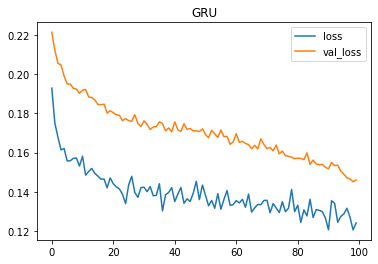

In [78]:
plt.plot(network1.history["loss"], label="loss")
plt.plot(network1.history["val_loss"], label="val_loss")
plt.legend()
plt.title("GRU")
plt.show()

In [79]:
bestGRU = load_model("GRU_epoch-97-loss-0.1218-.hdf5")

In [80]:
print("MAE for GRU is:",bestGRU.evaluate(testNormX,testNormY)[1])

15/15 [==============================] - 0s 5ms/step
MAE for GRU is: 0.09637109190225601


In [81]:
preds1 = bestGRU.predict(testNormX)

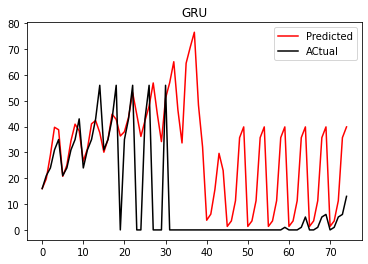

In [82]:
plt.plot(sc.inverse_transform(preds1.reshape(-1,1)), label="Predicted", color="red")
plt.plot(sc.inverse_transform(testNormY.reshape(-1,1)), label="ACtual", color="black")
plt.legend()
plt.title("GRU")
plt.show()

In [83]:
print("MAE for LSTM is:",lstmbest.evaluate(testNormX,testNormY)[1])

15/15 [==============================] - 0s 48us/step
MAE for LSTM is: 0.10972357541322708


In [84]:
print("MAE for GRU is:",bestGRU.evaluate(testNormX,testNormY)[1])

15/15 [==============================] - 0s 89us/step
MAE for GRU is: 0.09637109190225601


GRU outperforms LSTM in our example

In [85]:
from keras import layers

## 1D + GRU

In [86]:
Covmodel = Sequential()
Covmodel.add(layers.Conv1D(filters=64, kernel_size=trainNormX.shape[1], activation="relu", input_shape=trainNormX.shape[1:]))
Covmodel.add(GRU(24))
Covmodel.add(Dense(5, activation='linear'))
Covmodel.compile(loss="mae", optimizer="adam",metrics=["mean_absolute_error"])

In [87]:
Covmodel.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 1, 64)             192       
_________________________________________________________________
gru_4 (GRU)                  (None, 24)                6408      
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 125       
Total params: 6,725
Trainable params: 6,725
Non-trainable params: 0
_________________________________________________________________


In [88]:
# ONLY USE FOR BEST MODEL SELECTION
# network_name = "COVGRU"
# filepath = network_name + "_epoch-{epoch:02d}-loss-{loss:.4f}-.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor="val_loss", verbose=0, save_best_only=True, mode="min")
# callbacks_list = [checkpoint]
network2 = Covmodel.fit(trainNormX, trainNormY, validation_data=(valNormX, valNormY), epochs=100, batch_size=2)

Train on 96 samples, validate on 15 samples
Epoch 1/100
96/96 [==============================] - 1s 6ms/step - loss: 0.1930 - mean_absolute_error: 0.1930 - val_loss: 0.2245 - val_mean_absolute_error: 0.2245
Epoch 2/100
96/96 [==============================] - 0s 1ms/step - loss: 0.1717 - mean_absolute_error: 0.1717 - val_loss: 0.2033 - val_mean_absolute_error: 0.2033
Epoch 3/100
96/96 [==============================] - 0s 1ms/step - loss: 0.1605 - mean_absolute_error: 0.1605 - val_loss: 0.1904 - val_mean_absolute_error: 0.1904
Epoch 4/100
96/96 [==============================] - 0s 943us/step - loss: 0.1519 - mean_absolute_error: 0.1519 - val_loss: 0.1798 - val_mean_absolute_error: 0.1798
Epoch 5/100
96/96 [==============================] - 0s 930us/step - loss: 0.1423 - mean_absolute_error: 0.1423 - val_loss: 0.1714 - val_mean_absolute_error: 0.1714
Epoch 6/100
96/96 [==============================] - 0s 999us/step - loss: 0.1398 - mean_absolute_error: 0.1398 - val_loss: 0.1693 - val_

96/96 [==============================] - 0s 936us/step - loss: 0.0954 - mean_absolute_error: 0.0954 - val_loss: 0.0972 - val_mean_absolute_error: 0.0972
Epoch 100/100
96/96 [==============================] - 0s 878us/step - loss: 0.0937 - mean_absolute_error: 0.0937 - val_loss: 0.1012 - val_mean_absolute_error: 0.1012


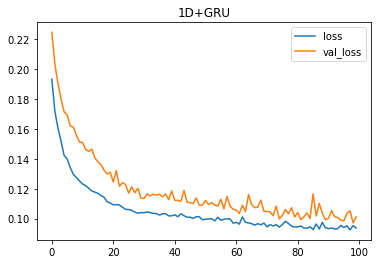

In [89]:
plt.plot(network2.history["loss"], label="loss")
plt.plot(network2.history["val_loss"], label="val_loss")
plt.legend()
plt.title("1D+GRU")
plt.show()

In [90]:
bestcovgru = load_model("COVGRU_epoch-89-loss-0.0932-.hdf5")

In [91]:
print("The MAE for best Cov 1D + GRU model is:",bestcovgru.evaluate(testNormX,testNormY)[1])

15/15 [==============================] - 0s 4ms/step
The MAE for best Cov 1D + GRU model is: 0.09015214443206787


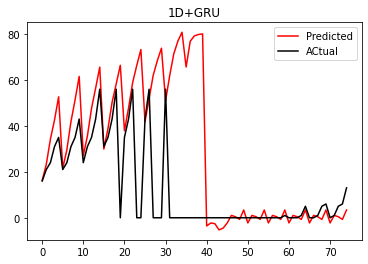

In [92]:
preds2 = bestcovgru.predict(testNormX)
plt.plot(sc.inverse_transform(preds2.reshape(-1,1)), label="Predicted", color="red")
plt.plot(sc.inverse_transform(testNormY.reshape(-1,1)), label="ACtual", color="black")
plt.legend()
plt.title("1D+GRU")
plt.show()

## 1D + LSTM

In [93]:
Covlstmmodel = Sequential()
Covlstmmodel.add(layers.Conv1D(filters=64, kernel_size=trainNormX.shape[1], activation="relu", input_shape=trainNormX.shape[1:]))
Covlstmmodel.add(LSTM(24))
Covlstmmodel.add(Dense(5, activation='linear'))
Covlstmmodel.compile(loss="mae", optimizer="adam",metrics=["mean_absolute_error"])

In [94]:
# ONLY USE FOR BEST MODEL SELECTION
# network_name = "COVLSTM"
# filepath = network_name + "_epoch-{epoch:02d}-loss-{loss:.4f}-.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor="val_loss", verbose=0, save_best_only=True, mode="min")
# callbacks_list = [checkpoint]
network3 = Covlstmmodel.fit(trainNormX, trainNormY, validation_data=(valNormX, valNormY), epochs=100, batch_size=2)

Train on 96 samples, validate on 15 samples
Epoch 1/100
96/96 [==============================] - 1s 6ms/step - loss: 0.1981 - mean_absolute_error: 0.1981 - val_loss: 0.2340 - val_mean_absolute_error: 0.2340
Epoch 2/100
96/96 [==============================] - 0s 1ms/step - loss: 0.1771 - mean_absolute_error: 0.1771 - val_loss: 0.2107 - val_mean_absolute_error: 0.2107
Epoch 3/100
96/96 [==============================] - 0s 1ms/step - loss: 0.1671 - mean_absolute_error: 0.1671 - val_loss: 0.1977 - val_mean_absolute_error: 0.1977
Epoch 4/100
96/96 [==============================] - 0s 940us/step - loss: 0.1579 - mean_absolute_error: 0.1579 - val_loss: 0.1872 - val_mean_absolute_error: 0.1872
Epoch 5/100
96/96 [==============================] - 0s 874us/step - loss: 0.1463 - mean_absolute_error: 0.1463 - val_loss: 0.1780 - val_mean_absolute_error: 0.1780
Epoch 6/100
96/96 [==============================] - 0s 937us/step - loss: 0.1378 - mean_absolute_error: 0.1378 - val_loss: 0.1652 - val_

96/96 [==============================] - 0s 1ms/step - loss: 0.0969 - mean_absolute_error: 0.0969 - val_loss: 0.1055 - val_mean_absolute_error: 0.1055
Epoch 51/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0962 - mean_absolute_error: 0.0962 - val_loss: 0.0981 - val_mean_absolute_error: 0.0981
Epoch 52/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0970 - mean_absolute_error: 0.0970 - val_loss: 0.1015 - val_mean_absolute_error: 0.1015
Epoch 53/100
96/96 [==============================] - 0s 821us/step - loss: 0.0964 - mean_absolute_error: 0.0964 - val_loss: 0.0970 - val_mean_absolute_error: 0.0970
Epoch 54/100
96/96 [==============================] - 0s 872us/step - loss: 0.0948 - mean_absolute_error: 0.0948 - val_loss: 0.1020 - val_mean_absolute_error: 0.1020
Epoch 55/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0961 - mean_absolute_error: 0.0961 - val_loss: 0.0964 - val_mean_absolute_error: 0.0964
Epoch 56/100
96/96 [=====

Epoch 100/100
96/96 [==============================] - 0s 851us/step - loss: 0.0941 - mean_absolute_error: 0.0941 - val_loss: 0.0941 - val_mean_absolute_error: 0.0941


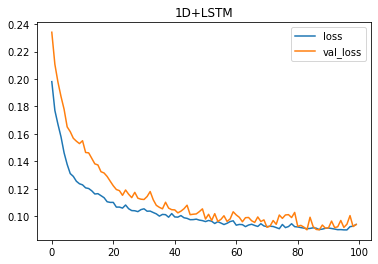

In [95]:
plt.plot(network3.history["loss"], label="loss")
plt.plot(network3.history["val_loss"], label="val_loss")
plt.legend()
plt.title("1D+LSTM")
plt.show()

In [96]:
bestcovlstm = load_model("COVLSTM_epoch-92-loss-0.0867-.hdf5")

In [97]:
print("The MAE for best Cov 1D + LSTM model is:",bestcovlstm.evaluate(testNormX,testNormY)[1])

15/15 [==============================] - 0s 4ms/step
The MAE for best Cov 1D + LSTM model is: 0.09125351160764694


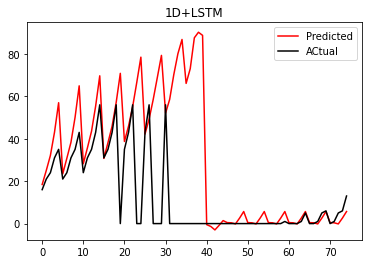

In [98]:
preds3 = bestcovlstm.predict(testNormX)
plt.plot(sc.inverse_transform(preds3.reshape(-1,1)), label="Predicted", color="red")
plt.plot(sc.inverse_transform(testNormY.reshape(-1,1)), label="ACtual", color="black")
plt.legend()
plt.title("1D+LSTM")
plt.show()

In [99]:
print("The MAE for best Cov 1D + LSTM model is:",bestcovlstm.evaluate(testNormX,testNormY)[1])

15/15 [==============================] - 0s 33us/step
The MAE for best Cov 1D + LSTM model is: 0.09125351160764694


In [100]:
print("The MAE for best Cov 1D + GRU model is:",bestcovgru.evaluate(testNormX,testNormY)[1])

15/15 [==============================] - 0s 65us/step
The MAE for best Cov 1D + GRU model is: 0.09015214443206787


1D + GRU slightly outperform 1D + LSTM

## My Approach

In [101]:
def nn():
    model = Sequential()
    model.add(Dense(32, activation="relu", input_dim=2))
    model.add(Dense(5, activation="linear"))
    model.compile(loss="mae", optimizer="adam",metrics=["mean_absolute_error"])
    return model

In [102]:
nnmodel=nn()

In [111]:
# ONLY USE FOR BEST MODEL SELECTION
# network_name = "Regular"
# filepath = network_name + "_epoch-{epoch:02d}-loss-{loss:.4f}-.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor="val_loss", verbose=0, save_best_only=True, mode="min")
# callbacks_list = [checkpoint]
network34 = nnmodel.fit(trainNormX.reshape(trainNormX.shape[0],trainNormX.shape[1]), trainNormY, validation_data=(valNormX.reshape(valNormX.shape[0],valNormX.shape[1]), valNormY), epochs=100, batch_size=2)

Train on 96 samples, validate on 15 samples
Epoch 1/100
96/96 [==============================] - 0s 647us/step - loss: 0.1010 - mean_absolute_error: 0.1010 - val_loss: 0.1157 - val_mean_absolute_error: 0.1157
Epoch 2/100
96/96 [==============================] - 0s 669us/step - loss: 0.1012 - mean_absolute_error: 0.1012 - val_loss: 0.1185 - val_mean_absolute_error: 0.1185
Epoch 3/100
96/96 [==============================] - 0s 640us/step - loss: 0.1009 - mean_absolute_error: 0.1009 - val_loss: 0.1129 - val_mean_absolute_error: 0.1129
Epoch 4/100
96/96 [==============================] - 0s 632us/step - loss: 0.1002 - mean_absolute_error: 0.1002 - val_loss: 0.1177 - val_mean_absolute_error: 0.1177
Epoch 5/100
96/96 [==============================] - 0s 582us/step - loss: 0.1008 - mean_absolute_error: 0.1008 - val_loss: 0.1157 - val_mean_absolute_error: 0.1157
Epoch 6/100
96/96 [==============================] - 0s 576us/step - loss: 0.1011 - mean_absolute_error: 0.1011 - val_loss: 0.1155 

96/96 [==============================] - 0s 676us/step - loss: 0.0943 - mean_absolute_error: 0.0943 - val_loss: 0.0979 - val_mean_absolute_error: 0.0979
Epoch 100/100
96/96 [==============================] - 0s 562us/step - loss: 0.0944 - mean_absolute_error: 0.0944 - val_loss: 0.0984 - val_mean_absolute_error: 0.0984


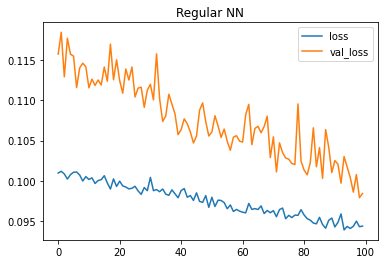

In [113]:
plt.plot(network34.history["loss"], label="loss")
plt.plot(network34.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Regular NN")
plt.show()

In [114]:
regularbest = load_model("Regular_epoch-99-loss-0.0959-.hdf5")

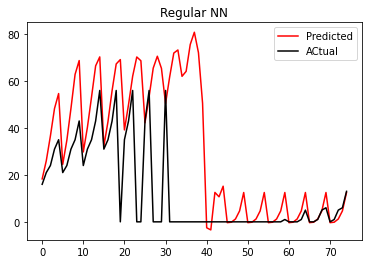

In [115]:
preds4 = regularbest.predict(testNormX.reshape(testNormX.shape[0],testNormX.shape[1]))
plt.plot(sc.inverse_transform(preds4.reshape(-1,1)), label="Predicted", color="red")
plt.plot(sc.inverse_transform(testNormY.reshape(-1,1)), label="ACtual", color="black")
plt.legend()
plt.title("Regular NN")
plt.show()

In [116]:
print("Regular NN MAE is:",regularbest.evaluate(testNormX.reshape(testNormX.shape[0],testNormX.shape[1]),testNormY)[1])

15/15 [==============================] - 0s 956us/step
Regular NN MAE is: 0.09577197581529617


In [117]:
print("The MAE for best Cov 1D + GRU model is:",bestcovgru.evaluate(testNormX,testNormY)[1])

15/15 [==============================] - 0s 131us/step
The MAE for best Cov 1D + GRU model is: 0.09015214443206787


In [118]:
print("The MAE for best Cov 1D + LSTM model is:",bestcovlstm.evaluate(testNormX,testNormY)[1])

15/15 [==============================] - 0s 92us/step
The MAE for best Cov 1D + LSTM model is: 0.09125351160764694


In [119]:
print("MAE for GRU is:",bestGRU.evaluate(testNormX,testNormY)[1])

15/15 [==============================] - 0s 83us/step
MAE for GRU is: 0.09637109190225601


In [120]:
print("MAE for LSTM is:",lstmbest.evaluate(testNormX,testNormY)[1])

15/15 [==============================] - 0s 54us/step
MAE for LSTM is: 0.10972357541322708


Because I want to compare the preformance on these three different NN, I choose to do regular NN in problem3. Generally speaking, CNN and RNN outperform regular NN on sequence data. The best model we got here is CNN 1D + GRU because GRU is usually better LSTM in small datasets. In this report, we only have a small dataset.